# Tutoriel Python

Ce tutoriel a pour but de guider les personnes souhaitant utiliser Python pour participer au challenge.

Il comporte cinq etapes :

* Import des donnees
* Analyse descriptive
* Preparation des donnees
* Creation d’un modele en cross validation
* Calcul des predictions et soumission

# Import des données

Avant de rentrer dans le vif du sujet, importons quelques packages necessaires pour ce tutoriel :

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Librairie de visualisation super cool
import seaborn as sns # pip install seaborn

Les datasets sont sous format .csv. Vous pouvez les importer avec le code ci-dessous.

In [24]:
train = pd.read_csv('D:/Dev/dataScience/kaggle/challenge_25_data/data/boites_medicaments_train.csv',
                    encoding='utf-8',
                    sep=';')

test = pd.read_csv('D:/Dev/dataScience/kaggle/challenge_25_data/data/boites_medicaments_test.csv',
                   encoding='utf-8', 
                   sep=';')

In [5]:
pd.set_option("display.max_columns", 99) # permet de voir toutes les colonnes
train.head(3)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30
2,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,2000,1996,Procédure nationale,MYLAN SAS,CHLORHYDRATE DE DILTIAZEM,5.66


On est maintenant pret a attaquer les choses serieuses ! :)

# Analyse descriptive

### Structure des datasets

Le dataset ```train``` comporte les caracteristiques et prix de 8564 boites de medicaments. C'est ce dataset que nous allons utiliser pour creer un modele.
Chaque boite de medicament est decrite par une observation de 41 variables. Ces variables sont decrites dans le fichier `Description.pdf` present dans la cle usb.

Le dataset ```test``` comporte les caracteristiques des 3671 boites de medicaments dont il faut predire le prix. A la difference de ```train```, le prix des boites de medicaments n'est bien sur pas inclus et une colonne `id` a ete ajoutée pour identifier les boites de medicaments pendant l'etape de soumission des predictions sur [Datascience.net](www.datascience.net)

### Distribution des donnees

Jetons maintenant un coup d'oeil a la distribution des donnees

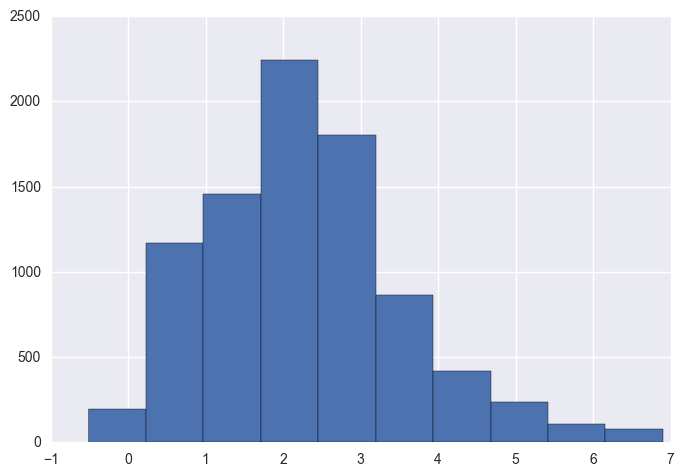

In [25]:
# Distribution du log des prix
# On prend le log des prix car sa distribution est plus proche d'une gaussienne
train['logprix'] = train['prix'].apply(np.log)
train['logprix'].hist()

Essai avec une sortie "log prix unitaire" au lieu de "log prix"
prix unitaire = nb de supports (plaquette, ampoule, flacon,...) * quantité par support (comprimés, gélule, ml,...)

In [51]:
## chu
train['cst1'] = 1
test['cst1'] = 1
train['nb'] = (train[['nb_plaquette', 'nb_ampoule', 'nb_flacon', 'nb_tube', 'nb_ampoule', 'nb_flacon', 'nb_tube', 
              'nb_stylo', 'nb_seringue', 'nb_pilulier', 'nb_sachet', 'nb_film', 'nb_poche', 'cst1']].max(axis=1) 
              * train[['nb_comprime', 'nb_gelule', 'nb_capsule', 'nb_ml', 'cst1']].max(axis=1))
test['nb'] = (test[['nb_plaquette', 'nb_ampoule', 'nb_flacon', 'nb_tube', 'nb_ampoule', 'nb_flacon', 'nb_tube', 
              'nb_stylo', 'nb_seringue', 'nb_pilulier', 'nb_sachet', 'nb_film', 'nb_poche', 'cst1']].max(axis=1) 
              * test[['nb_comprime', 'nb_gelule', 'nb_capsule', 'nb_ml', 'cst1']].max(axis=1))

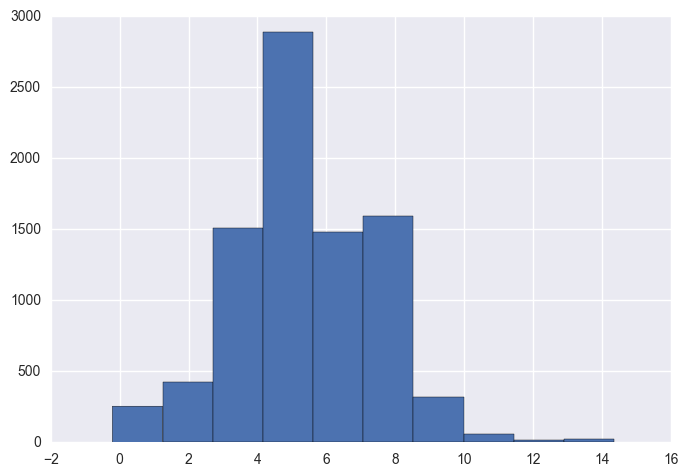

In [54]:
# Visualisation distribution 'logprixunit'
train['prixunit'] = train['nb'] * train['prix']
train['logprixunit'] = train['prixunit'].apply(np.log)
train['logprixunit'].hist()
# la distribution est plus éloignée d'une gaussienne que pour 'logprix'. 
# L'évaluation du modèle avec la sortie 'logprixunit' est effectivement moins permormante (+ 7/8%)

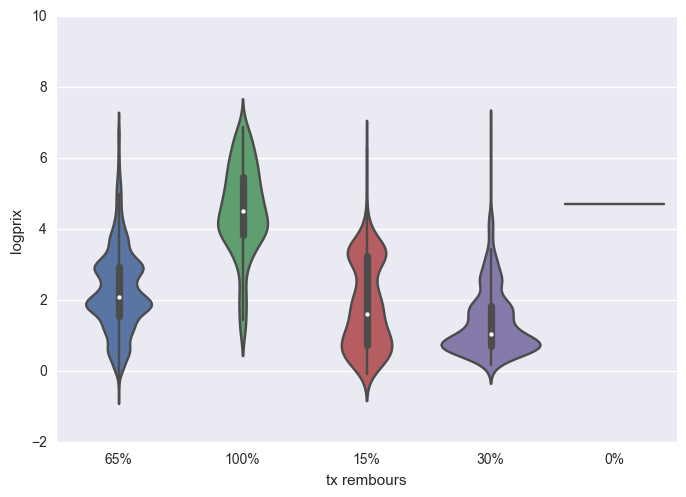

In [26]:
# Influence sur les prix de la feature "tx rembours"
sns.violinplot(y="logprix", x="tx rembours", data=train)

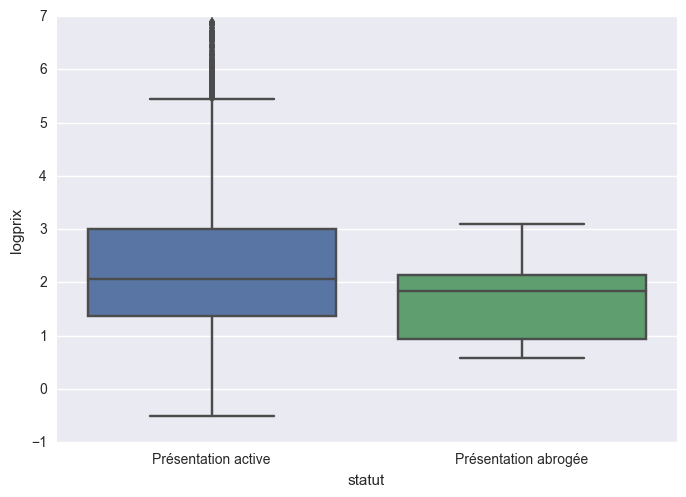

In [10]:
# Influence sur les prix de la feature "statut"
sns.boxplot(y="logprix", x="statut", data=train)

# Preparation des donnees

### Types de features

In [27]:
# features numériques
feat_num = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule'] + ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml']
# features date
feat_dates = ['date declar annee', 'date amm annee']
# features catégorielles
feat_cat = ['statut', 'etat commerc', 'agrement col', 'tx rembours',
          'voies admin', 'statut admin', 'type proc']
# features texte
feat_text = ['libelle', 'titulaires', 'substances', 'forme pharma']

### Encodage des features catégorielles

Les algorithmes de machine learning s'attendent à avoir en entrée des nombres, et non pas des chaînes de caractères. C'est pourquoi nous transformons les features catégorielles en nombres, à l'aide de LabelEncoder()

In [28]:
for c in feat_cat:
    le = LabelEncoder()
    le.fit(train[c].append(test[c]))
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

 ### Split des catégories multi-valeurs
 Les catégories dont les valeurs sont des listes d'éléments sont développées sous forme de n catégories binaires (n étant le nombre d'éléments distincts pour la catégorie dans le dataset) 

In [32]:
## chug
def expandedOHE(train_df, test_df, colName):
    # type: (DataFrame, DataFrame, str) -> *str
    distinctCategs = (train_df[colName]
                      .apply(lambda st : st.split(','))
                      .apply(pd.Series)
                      .unstack()
                      .dropna()
                      .str.strip()
                      .unique())
    for categorie in distinctCategs:
        train_df[categorie] = train_df[colName].apply(lambda x : 1 if categorie in x else 0)
        test_df[categorie] = test_df[colName].apply(lambda x : 1 if categorie in x else 0)
    return list(distinctCategs) 

In [33]:
## chug : le split de la categorie "substances" permet de passer de 45 à 32%
feat_substances = expandedOHE(train, test, 'substances') 

## le split de la categorie "voies admin" dégrade l'estimation
#feat_substances = expandedOHE(train, test, 'substances') 

In [36]:
train['CHLORHYDRATE DE DILTIAZEM'].head(3)

0    0
1    0
2    1
Name: CHLORHYDRATE DE DILTIAZEM, dtype: int64

# Creation d'un modele

Il est maintenant temps de creer un modele. Dans ce tutoriel nous allons construire une [Foret Aleatoire](https://fr.wikipedia.org/wiki/For%C3%AAt_d'arbres_d%C3%A9cisionnels)

Pour ce faire nous utilisons toutes les variables dont nous disposons, sauf les variables de type "texte".

Pour eviter le [surapprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) et estimer les vraies performances de notre modele nous allons utiliser le critère de [validation croisee](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) (cross-validation) methode k-fold.

### Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [37]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Cross validation

In [56]:
err = 0
NBROUND = 5
FEATURES = feat_num + feat_cat + feat_substances ## chug on ajoute les feat_substances
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestRegressor()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print mape_error(np.exp(y_test), np.exp(pred))
print "*** MAPE Error : ", err / NBROUND

33.3527281061
38.5169300114
33.3072497645
36.2011610522
30.7308911441
*** MAPE Error :  34.4217920157


Cela veut dire notre modele predit les prix des medicaments avec environ 65% d’erreur en moyenne. Par exemple, si un medicament vaut reellement 10€, notre prediction sera de 16.5€ (ou 3.5€).

## chug
Estimations de base : 65%

Optimisations :
- Ajout catégorie "substances" : 45%
- Ajout catégorie "substances splitées" : 33%

Dégradations :
- logprixnuit : +7/8%

# Calcul des predictions et soumission

In [18]:
clf = RandomForestRegressor()
# On entraine de nouveau le modèle, cette fois sur l'intégralité des données
clf.fit(train[FEATURES], train['logprix'])
predictions = np.exp(clf.predict(test[FEATURES]))

In [19]:
pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv',  
                          header=['prix'],
                          sep = ';')

Vous etes maintenant pret ? Faites votre premiere soumission en uplodant le fichier `soumission.csv` sur [Datascience.net](www.datascience.net)